# Pick and Place
This notebook presents the demonstration of pick and place of two books (boxes) for the LibreBot by T2325.

In [1]:
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import SVG, clear_output, display
from pydrake.all import (AddMultibodyPlantSceneGraph, AngleAxis,
                         DiagramBuilder, FindResourceOrThrow, Integrator,
                         JacobianWrtVariable, LeafSystem, MathematicalProgram,
                         MeshcatVisualizer, SnoptSolver, Solve, eq, ge, le,
                         MultibodyPlant, MultibodyPositionToGeometryPose,
                         Parser, PiecewisePolynomial, PiecewisePose,
                         Quaternion, Rgba, RigidTransform, RotationMatrix,
                         SceneGraph, Simulator, StartMeshcat, TrajectorySource)

from manipulation import running_as_notebook, FindResource
from manipulation.scenarios import *
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.manipulation.planner import (
    DifferentialInverseKinematicsIntegrator,
    DifferentialInverseKinematicsParameters,
    DifferentialInverseKinematicsStatus)
from pydrake.manipulation.planner import DoDifferentialInverseKinematics
from datetime import datetime


if running_as_notebook:
    mpld3.enable_notebook()


def saat(msg=""):
    print(str(datetime.now())," ", msg)
saat()

2023-04-05 14:16:29.794047   


In [2]:
print(str(datetime.now()))
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://29fb9f43-5ddf-4394-96be-7b378ea2c223.deepnoteproject.com/7000/
2023-04-05 14:16:29.800074
Installing NginX server for MeshCat on Deepnote...


In [3]:
def MakeGripperFrames(X_G, X_O, X_O2):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the pick and place
    frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    # p_GgraspO = [0.0, 0.35, -0.03]  # x değil başka bişey,  or X_GgraspGpregrasp
    # R_GgraspO = RotationMatrix.MakeYRotation(
    #    -np.pi / 2.0
    # ) @ RotationMatrix.MakeZRotation(-np.pi / 2.0)
    # X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    # X_OGgrasp = X_GgraspO.inverse()
    X_OGgrasp = RigidTransform(
        RotationMatrix.MakeYRotation(np.pi / 2.0)
        @ RotationMatrix.MakeXRotation(-np.pi / 2.0),
        [0.1, 0.02, 0],
    )

    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GgraspGpregrasp = RigidTransform(
        [0, -0.15, -0.05]
    )  # RigidTransform([0, -0.15, 0])  # or this is wrong, change to +x?

    X_G["pick"] = X_O["initial"] @ X_OGgrasp
    X_G["prepick"] = X_G["pick"] @ X_GgraspGpregrasp
    X_G["place"] = X_O["goal"] @ X_OGgrasp
    
    X_Preplace = RigidTransform(
        [0, -0.2, -0.05]
    )
    X_G["preplace"] = X_G["place"] @ X_Preplace

    # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
    X_GprepickGpreplace = X_G["prepick"].inverse() @ X_G["preplace"]
    angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    X_GprepickGclearance = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        X_GprepickGpreplace.translation() / 2.0 + np.array([0, 0, -0.3]),
    )
    X_G["clearance"] = X_G["prepick"] @ X_GprepickGclearance

    # Now let's set the timing
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse() @ X_G["prepick"]
    times["prepick"] = times["initial"] + 10.0 * np.linalg.norm(
        X_GinitialGprepick.translation()
    )
    # Allow some time for the gripper to close.
    times["pick_start"] = times["prepick"] + 2.0
    times["pick_end"] = times["pick_start"] + 2.0
    X_G["pick_start"] = X_G["pick"]
    X_G["pick_end"] = X_G["pick"]
    times["postpick"] = times["pick_end"] + 2.0
    X_G["postpick"] = X_G["prepick"]
    time_to_from_clearance = 10.0 * np.linalg.norm(X_GprepickGclearance.translation())
    times["clearance"] = times["postpick"] + time_to_from_clearance
    times["preplace"] = times["clearance"] + time_to_from_clearance
    times["place_start"] = times["preplace"] + 2.0
    times["place_end"] = times["place_start"] + 2.0
    X_G["place_start"] = X_G["place"]
    X_G["place_end"] = X_G["place"]
    times["postplace"] = times["place_end"] + 2.0
    X_G["postplace"] = X_G["preplace"]

    # ---------------------------------------#

    # redo same thing for object 2

    X_OGgrasp2 = RigidTransform(
        RotationMatrix.MakeYRotation(np.pi / 2.0)
        @ RotationMatrix.MakeXRotation(-np.pi / 2.0),
        [
            0.09,
            0,
            0.0,
        ],  # y 0 idi x kutudan uzaklasıp yakıınlastırıyor, y kutu içinde sol sağ , z yukarıa aşa
    )  # x = 0.008 sol taraff x Y = -0.04  , y = -0.01 son  şimdi 0.02

    # X_GgraspGpregrasp = RigidTransform([0.05, -0.15, -0.05]) #RigidTransform([0, -0.15, 0])  # or this is wrong, change to +x?
    # 0.02

    times["initial2"] = times["postplace"] + 2.0
    X_G["initial2"] = X_G["postplace"]  # aynı yerde kalıyor

    X_G["pick2"] = X_O2["initial"] @ X_OGgrasp2
    X_G["prepick2"] = X_G["pick2"] @ X_GgraspGpregrasp
    X_G["place2"] = X_O2["goal"] @ X_OGgrasp2
    X_G["preplace2"] = X_G["place2"] @ X_GgraspGpregrasp

    # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
    X_GprepickGpreplace2 = X_G["prepick2"].inverse() @ X_G["preplace2"]
    angle_axis2 = X_GprepickGpreplace2.rotation().ToAngleAxis()
    X_GprepickGclearance2 = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis2.axis()),
        X_GprepickGpreplace2.translation() / 2.0 + np.array([0, 0, -0.3]),
    )
    X_G["clearance2"] = X_G["prepick2"] @ X_GprepickGclearance2

    X_GinitialGprepick2 = X_G["initial"].inverse() @ X_G["prepick2"]

    times["prepick2"] = times["initial2"] + 10.0 * np.linalg.norm(
        X_GinitialGprepick2.translation()
    )

    # Allow some time for the gripper to close.
    times["pick_start2"] = times["prepick2"] + 2.0
    times["pick_end2"] = times["pick_start2"] + 2.0
    X_G["pick_start2"] = X_G["pick2"]
    X_G["pick_end2"] = X_G["pick2"]
    times["postpick2"] = times["pick_end2"] + 4.0
    X_G["postpick2"] = X_G["prepick2"]
    time_to_from_clearance = 10.0 * np.linalg.norm(X_GprepickGclearance2.translation())
    times["clearance2"] = times["postpick2"] + time_to_from_clearance
    times["preplace2"] = times["clearance2"] + time_to_from_clearance
    times["place_start2"] = times["preplace2"] + 2.0
    times["place_end2"] = times["place_start2"] + 2.0
    X_G["place_start2"] = X_G["place2"]
    X_G["place_end2"] = X_G["place2"]
    times["postplace2"] = times["place_end2"] + 2.0
    X_G["postplace2"] = X_G["preplace2"]

    """
    X_G["prepick2"] = X_G["prepick"]
    times["prepick2"] = times["postplace"] + 8.0

    
    X_G["pick_start2"] = X_G["pick_start"]
    times["pick_start2"] = times["prepick2"] + 2.0

    X_G["pick_end2"] = X_G["pick_end"]
    times["pick_end2"] = times["pick_start2"] + 2.0

    X_G["postpick2"] = X_G["postpick"]
    times["postpick2"] = times["pick_end2"] + 2.0
    """

    return X_G, times


X_G = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0), [0, -0.25, 0.25]
    )
}
# X_O = {
#    "initial":
#        RigidTransform(RotationMatrix.MakeZRotation(np.pi / 2.0),
#                       [-.2, -.75, 0.025]),
#    "goal":
#        RigidTransform(RotationMatrix.MakeZRotation(np.pi), [.75, 0, 0.025])
# }

X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0)
        @ RotationMatrix.MakeYRotation(-np.pi / 2.0),
        [0, -0.95, 0.45],
    ),
    "goal": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0)
        @ RotationMatrix.MakeYRotation(-np.pi),
        [0.99, 0.0, 0.49],  # [0.5, 0.05, -0.015]
    ),
}

X_O2 = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0)
        @ RotationMatrix.MakeYRotation(-np.pi / 2.0),
        [-0.15, -0.95, 0.45],
    ),
    "goal": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0)
        @ RotationMatrix.MakeYRotation(-np.pi),
        [0.99, 0.15, 0.5],  # [0.5, 0.05, -0.015]
    ),
}

X_G, times = MakeGripperFrames(X_G, X_O, X_O2)  # old was X_G ,times
print(
    f"Sanity check: The entire maneuver will take {times['postplace2']} seconds to execute."
)


Sanity check: The entire maneuver will take 64.2719826541499 seconds to execute.


In [4]:
X_G

{'initial': RigidTransform(
   R=RotationMatrix([
     [1.0, 0.0, 0.0],
     [0.0, 6.123233995736766e-17, 1.0],
     [0.0, -1.0, 6.123233995736766e-17],
   ]),
   p=[0.0, -0.25, 0.25],
 ),
 'pick': RigidTransform(
   R=RotationMatrix([
     [1.0, 0.0, 0.0],
     [0.0, -1.0, 1.2246467991473532e-16],
     [0.0, -1.2246467991473532e-16, -1.0],
   ]),
   p=[6.123233995736766e-18, -0.85, 0.43],
 ),
 'prepick': RigidTransform(
   R=RotationMatrix([
     [1.0, 0.0, 0.0],
     [0.0, -1.0, 1.2246467991473532e-16],
     [0.0, -1.2246467991473532e-16, -1.0],
   ]),
   p=[6.123233995736766e-18, -0.7, 0.48],
 ),
 'place': RigidTransform(
   R=RotationMatrix([
     [6.123233995736766e-17, 1.0, -6.123233995736766e-17],
     [1.0, -6.123233995736766e-17, 6.123233995736767e-17],
     [6.123233995736766e-17, -6.123233995736767e-17, -1.0],
   ]),
   p=[0.89, 1.3471114790620886e-17, 0.47],
 ),
 'preplace': RigidTransform(
   R=RotationMatrix([
     [6.123233995736766e-17, 1.0, -6.123233995736766e-17],
   

# Pick and place trajectories

We've defined the keyframes, but now we will fill in timing details (what should be happening at each instant).

Interpolating between the positions is quite simple; we can encode these details as a `PiecewisePolynomial` trajectory in $\Re^3$ over time.  Interpolating over orientations requires more care.  We'll use `PiecewiseQuaternionSlerp` to do the job.

See the documentation of [PiecewisePose](https://drake.mit.edu/doxygen_cxx/classdrake_1_1trajectories_1_1_piecewise_pose.html#ae2f8a49b642aecb5c19ef3625be5e61d) for more details.

In [5]:
def MakeGripperPoseTrajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for name in ["initial", "prepick", "pick_start", "pick_end", "postpick",
                 "clearance", "preplace", "place_start", "place_end",
                 "postplace",
                 "initial2", "prepick2", "pick_start2", "pick_end2", "postpick2",
                 "clearance2", "preplace2", "place_start2", "place_end2",
                 "postplace2"]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)

traj_X_G = MakeGripperPoseTrajectory(X_G, times)




Now let's plot our trajectories.

In [6]:
traj_p_G = traj_X_G.get_position_trajectory()

p_G = traj_p_G.vector_values(traj_p_G.get_segment_times())
plt.plot(traj_p_G.get_segment_times(), p_G.T)
plt.legend(['x', 'y', 'z'])
plt.title('p_G')
mpld3.display()

We can also plot the trajectory in 3D directly in Meshcat.

In [7]:
meshcat.ResetRenderMode()
meshcat.SetLine('p_G', p_G, 2.0, rgba=Rgba(1, 0.65, 0))
AddMeshcatTriad(meshcat, "X_Oinitial", X_PT=X_O2["initial"])
AddMeshcatTriad(meshcat, "X_Gprepick2", X_PT= X_G["prepick2"])
for name in ["initial", "prepick", "pick_start", "pick_end", "postpick",
                 "clearance", "preplace", "place_start", "place_end",
                 "postplace",
                 "initial2", "prepick2", "pick_start2", "pick_end2", "postpick2",
                 "clearance2", "preplace2", "place_start2", "place_end2",
                 "postplace2"]:
    AddMeshcatTriad(meshcat, "X_G" + name, X_PT= X_G[name])

#1/0

We can plot the orientation trajectory, too.  Here are the components of the quaternion over time.

In [8]:
traj_R_G = traj_X_G.get_orientation_trajectory()
R_G = traj_R_G.vector_values(traj_R_G.get_segment_times())
plt.plot(traj_R_G.get_segment_times(), R_G.T)
plt.legend(['qx', 'qy', 'qz', 'qw'])
plt.title('R_G')
mpld3.display()

Better, I think, to just plot the entire result.  Before we do, let's quickly define the finger trajectory.

In [9]:

def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107]);
    closed = np.array([0.0]);

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]], np.hstack([[opened], [opened]]))
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["pick_start2"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end2"], closed)
    #traj_wsg_command.AppendFirstOrderSegment(times["place_start2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace2"], opened)



    return traj_wsg_command

traj_wsg_command = MakeGripperCommandTrajectory(times)

In [10]:
wsg_command = traj_wsg_command.vector_values(
    traj_wsg_command.get_segment_times())
plt.plot(traj_wsg_command.get_segment_times(), wsg_command.T)
plt.title('wsg_command')
mpld3.display()

Now let's really visualize the trajectory.  The best way is to animate it in 3D!  Please forgive the messiness of this particular bit of code; I'm trying to provide some intermediate steps that aren't typically used by the main drake developers.

TODO(russt): make this less "bespoke".

In [11]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
        self.left_finger_joint = plant.GetJointByName("left_finger_sliding_joint")
        self.right_finger_joint = plant.GetJointByName("right_finger_sliding_joint")
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort(
            "position", plant.num_positions(), self.CalcPositionOutput
        )

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t))
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)
        self.left_finger_joint.set_translation(self.plant_context, -wsg / 2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg / 2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))


def visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant, scene_graph)
    gripper = parser.AddModelFromFile(
        FindResourceOrThrow(
            "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
        ),
        "gripper",
    )
    #brick = FindResourceOrThrow(
    #    "drake/examples/manipulation_station/models/061_foam_brick.sdf"
    brick = FindResourceOrThrow(
         "drake/manipulation/models/ycb/sdf/003_cracker_box.sdf"
    )
    for key, pose in X_O.items():
        o = parser.AddModelFromFile(brick, f"object_{key}")
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link_cracker", o), pose
        )
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(
        to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id()),
    )

    traj_to_position = builder.AddSystem(
        GripperTrajectoriesToPosition(plant, traj_p_G, traj_R_G, traj_wsg_command)
    )
    builder.Connect(traj_to_position.get_output_port(), to_pose.get_input_port())

    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    # TODO(russt): get recording working again with new Meshcat (and remove realtime rate)
     #meshcat.start_recording()
    if running_as_notebook:
        simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    #meshcat.publish_recording()

#visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)


# Putting it all together

In the visualization above, we animated the plan, but did not actually command the robot!  Let's put our grasping trajectories back together with our Jacobian-based controller.

The first thing you might have noticed is that the Jacobian controller takes spatial velocities as input.  But so far we have trajectories for positions and orientations.  Let's differentiate them to get the velocities.

In [12]:
traj_v_G = traj_p_G.MakeDerivative()

v_G = traj_v_G.vector_values(traj_v_G.get_segment_times())
plt.plot(traj_v_G.get_segment_times(), v_G.T)
plt.legend(['vx', 'vy', 'vz'])
plt.title('v_G')
mpld3.display()

Now we need a slightly modified version of our Jacobian controller, which can take the spatial velocity commands from an input port.

In [13]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa_position", 10)
        self.DeclareVectorOutputPort("iiwa_velocity", 10, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_0_x").velocity_start() #  todo joint_1?
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

        self.fancy_v = [0,0,0,0,0,0,0, 0, 0, 0] #np.zeros(7)


    

    def CalcOutput(self, context, output):
        def AddIiwaDifferentialIKNoInteg(q_current, v_current, V, J):
            params = DifferentialInverseKinematicsParameters(10,10) # 7 pos, 7 velocity params
            q0 = self._plant.GetPositions(self._plant_context)

            #params.set_nominal_joint_position(q0)
            params.set_end_effector_angular_speed_limit(2)
            trans_velocity_limits = [2, 2, 2]
            params.set_end_effector_translational_velocity_limits([-2, -2, -2], [2, 2, 2])
            iiwa14_velocity_limits = np.array([ 2,2,2, 1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
            params.set_joint_velocity_limits((-iiwa14_velocity_limits, iiwa14_velocity_limits))
            params.set_joint_centering_gain(10 * np.eye(10))
            result = DoDifferentialInverseKinematics(
                q_current=q_current,
                v_current=v_current,
                V=V,
                J=J,
                parameters=params)
            if result.status == DifferentialInverseKinematicsStatus.kSolutionFound:
                aaa = result.joint_velocities
            else:
                print("Differential inverse kinematics failed!")
                aaa = np.zeros(10)
            return aaa

        def DiffIKQP(J_G, V_G_desired, q_now, p_now):

            prog = MathematicalProgram()
            v = prog.NewContinuousVariables(7, 'v')
            a = prog.NewContinuousVariables(1, 'a')

            v_max = 1.0 # was 3.0 do not modify 
            e = 0.01
            # Add cost and constraints to prog here.
            error = J_G @ v - np.asarray(V_G_desired)
            secondary_error = 0
            prog.AddCost(-100 * a )
            prog.AddBoundingBoxConstraint(-v_max, v_max, v)

            solver = SnoptSolver()
            result = solver.Solve(prog)

            if not (result.is_success()):
                raise ValueError("Could not find the optimal solution.")

            v_solution = result.GetSolution(v)

            return v_solution

        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, # JacobianWrtVariable.kQDot?
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        X_now = self._plant.CalcRelativeTransform(self._plant_context,
                                                     self._W, self._G)
        p_now = X_now.translation()

        v = AddIiwaDifferentialIKNoInteg(q, self.fancy_v, V_G, J_G)
        self.fancy_v = v
        #v = DiffIKQP(J_G, V_G, q, p_now)
        #v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

Oh, boy.  Big moment.  I'm excited... are you?  Let's do this thing!

In [14]:
#X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.65, 0.0]),
#       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.5, 0, 0.0])}

builder = DiagramBuilder()

model_directives = """
directives:
- add_model:
    name: iiwa
    file: file://root/work/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf    

    # file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf    
    default_joint_positions:
        iiwa_joint_0_x: [0]
        iiwa_joint_0_y: [0]
        iiwa_joint_0_z: [0]
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}


- add_frame:
    name: shelf0_origin
    X_PF:
      base_frame: world
      rotation: !Rpy { deg: [0.0, 0, 90.0 ]}
      translation: [-0.1, -1.05, 0.45]

- add_model:
    name: shelf0
    file: package://manipulation/shelves.sdf

- add_weld:
    parent: shelf0_origin
    child: shelf0::shelves_body

- add_frame:
    name: shelf1_goal
    X_PF:
      base_frame: world
      rotation: !Rpy { deg: [0.0, 0, 180.0 ]}
      translation: [1.05, 0.05, 0.48]

- add_model:
    name: shelf1
    file: package://manipulation/shelves.sdf

- add_weld:
    parent: shelf1_goal
    child: shelf1::shelves_body

- add_model:
    name: floor
    file: package://manipulation/floor.sdf

- add_weld:
    parent: world
    child: floor::box
    X_PC:
        translation: [0, 0, -.5]
    
- add_model:
    name: cracker_box
    file: package://drake/manipulation/models/ycb/sdf/003_cracker_box.sdf

- add_model:
    name: sugar_box
    file: package://drake/manipulation/models/ycb/sdf/004_sugar_box.sdf
""" 

def CustomAddIiwaDifferentialIK(builder, plant, frame=None):
    params = DifferentialInverseKinematicsParameters(plant.num_positions(),
                                                     plant.num_velocities())
    time_step = plant.time_step()
    q0 = plant.GetPositions(plant.CreateDefaultContext())
    params.set_nominal_joint_position(q0)
    params.set_end_effector_angular_speed_limit(2)
    params.set_end_effector_translational_velocity_limits([-2, -2, -2],
                                                          [2, 2, 2])
    if plant.num_positions() == 3:  # planar iiwa
        iiwa14_velocity_limits = np.array([1.4, 1.3, 2.3])
        params.set_joint_velocity_limits(
            (-iiwa14_velocity_limits, iiwa14_velocity_limits))
        # These constants are in body frame
        assert (
            frame.name() == "iiwa_link_7"
        ), "Still need to generalize the remaining planar diff IK params for different frames"  # noqa
        params.set_end_effector_velocity_flag(
            [True, False, False, True, False, True])
    else:
        iiwa14_velocity_limits = np.array([2, 2, 2, 1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
        params.set_joint_velocity_limits(
            (-iiwa14_velocity_limits, iiwa14_velocity_limits))
        params.set_joint_centering_gain(10 * np.eye(10))
    if frame is None:
        frame = plant.GetFrameByName("body")
    differential_ik = builder.AddSystem(
        DifferentialInverseKinematicsIntegrator(
            plant,
            frame,
            time_step,
            params,
            log_only_when_result_state_changes=True))
    return differential_ik

def CustomMakeManipulationStation(model_directives=None,
                            filename=None,
                            time_step=0.002,
                            iiwa_prefix="iiwa",
                            wsg_prefix="wsg",
                            camera_prefix="camera",
                            prefinalize_callback=None,
                            package_xmls=[]):
    """

    """
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder,
                                                     time_step=time_step)
    parser = Parser(plant)
    for p in package_xmls:
        parser.package_map().AddPackageXml(p)
    AddPackagePaths(parser)
    if model_directives:
        directives = LoadModelDirectivesFromString(model_directives)
        ProcessModelDirectives(directives, parser)
    if filename:
        parser.AddAllModelsFromFile(filename)
    if prefinalize_callback:
        prefinalize_callback(plant)
    plant.Finalize()

    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)

        if model_instance_name.startswith(iiwa_prefix):
            num_iiwa_positions = plant.num_positions(model_instance)
            print(model_instance_name, " num_iiwa_positions:",num_iiwa_positions)
            # I need a PassThrough system so that I can export the input port.
            iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
            builder.ExportInput(iiwa_position.get_input_port(),
                                model_instance_name + "_position")
            builder.ExportOutput(iiwa_position.get_output_port(),
                                 model_instance_name + "_position_commanded")

            # Export the iiwa "state" outputs.
            demux = builder.AddSystem(
                Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions))
            print('size: ',plant.get_state_output_port(model_instance).size(), ' ',
                            demux.get_input_port().size())
            
            print('size: ',demux.get_output_port(0).size(), ' ',
                            demux.get_output_port(1).size())

            

            builder.Connect(plant.get_state_output_port(model_instance),
                            demux.get_input_port())
            builder.ExportOutput(demux.get_output_port(0),
                                 model_instance_name + "_position_measured")
            builder.ExportOutput(demux.get_output_port(1),
                                 model_instance_name + "_velocity_estimated")
            builder.ExportOutput(plant.get_state_output_port(model_instance),
                                 model_instance_name + "_state_estimated")

            # Make the plant for the iiwa controller to use.
            controller_plant = MultibodyPlant(time_step=time_step)
            # # TODO: Add the correct IIWA model (introspected from MBP)
            # if plant.num_positions(model_instance) == 3:
            #     controller_iiwa = AddPlanarIiwa(controller_plant)
            # else:
            # controller_iiwa = AddIiwa(controller_plant)
            sdf_path = FindResourceOrThrow(
                "drake/manipulation/models/iiwa_description/iiwa7/"
                f"iiwa7_no_collision.sdf")

            # AddIiwa {
            parser = Parser(controller_plant)
            controller_iiwa = parser.AddModelFromFile("iiwa_description/iiwa7/iiwa7_no_collision.sdf")
            # controller_iiwa = parser.AddModelFromFile("package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf") 
            # controller_iiwa = parser.AddModelFromFile(sdf_path)

            controller_plant.WeldFrames(controller_plant.world_frame(), controller_plant.GetFrameByName("iiwa_link_0"))
          
          
            # Set default positions:
            q0 = [0, 0, 0, 0.0, 0.1, 0, -1.2, 0, 1.6, 0]
            index = 0
            for joint_index in controller_plant.GetJointIndices(controller_iiwa):
                joint = controller_plant.get_mutable_joint(joint_index)
                if isinstance(joint, RevoluteJoint):
                    joint.set_default_angle(q0[index])
                    index += 1
                if isinstance(joint, PrismaticJoint):
                    joint.set_default_translation(q0[index])
                    index += 1
                
            # } AddIiwa
            #add_freebox(controller_plant) 
                

            AddWsg(controller_plant, controller_iiwa, welded=True)
            controller_plant.Finalize()

            kp=np.array([100] * num_iiwa_positions)
            print("num_iiwa_positions ", num_iiwa_positions)
            print("dim=kp.size() ", kp.size)
            print("controller_plant.num_positions ", controller_plant.num_positions())
            print("controller_plant.num_velocities ", controller_plant.num_velocities())
            print("controller_plant.num_actuators ", controller_plant.num_actuators())
            # Add the iiwa controller
            iiwa_controller = builder.AddSystem(
                InverseDynamicsController(controller_plant,
                                          kp=[100] * num_iiwa_positions,
                                          ki=[1] * num_iiwa_positions,
                                          kd=[20] * num_iiwa_positions,
                                          has_reference_acceleration=False))
            iiwa_controller.set_name(model_instance_name + "_controller")
            builder.Connect(plant.get_state_output_port(model_instance),
                            iiwa_controller.get_input_port_estimated_state())

            # Add in the feed-forward torque
            adder = builder.AddSystem(Adder(2, num_iiwa_positions))
            builder.Connect(iiwa_controller.get_output_port_control(),
                            adder.get_input_port(0))
            # Use a PassThrough to make the port optional (it will provide zero
            # values if not connected).
            torque_passthrough = builder.AddSystem(
                PassThrough([0] * num_iiwa_positions))
            builder.Connect(torque_passthrough.get_output_port(),
                            adder.get_input_port(1))
            builder.ExportInput(torque_passthrough.get_input_port(),
                                model_instance_name + "_feedforward_torque")
            builder.Connect(adder.get_output_port(),
                            plant.get_actuation_input_port(model_instance))

            # Add discrete derivative to command velocities.
            desired_state_from_position = builder.AddSystem(
                StateInterpolatorWithDiscreteDerivative(
                    num_iiwa_positions,
                    time_step,
                    suppress_initial_transient=True))
            desired_state_from_position.set_name(
                model_instance_name + "_desired_state_from_position")
            builder.Connect(desired_state_from_position.get_output_port(),
                            iiwa_controller.get_input_port_desired_state())
            builder.Connect(iiwa_position.get_output_port(),
                            desired_state_from_position.get_input_port())

            # Export commanded torques.
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_commanded")
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_measured")

            builder.ExportOutput(
                plant.get_generalized_contact_forces_output_port(
                    model_instance), model_instance_name + "_torque_external")

        elif model_instance_name.startswith(wsg_prefix):

            # Wsg controller.
            wsg_controller = builder.AddSystem(SchunkWsgPositionController())
            wsg_controller.set_name(model_instance_name + "_controller")
            builder.Connect(wsg_controller.get_generalized_force_output_port(),
                            plant.get_actuation_input_port(model_instance))
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_controller.get_state_input_port())
            builder.ExportInput(
                wsg_controller.get_desired_position_input_port(),
                model_instance_name + "_position")
            builder.ExportInput(wsg_controller.get_force_limit_input_port(),
                                model_instance_name + "_force_limit")
            wsg_mbp_state_to_wsg_state = builder.AddSystem(
                MakeMultibodyStateToWsgStateSystem())
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_mbp_state_to_wsg_state.get_input_port())
            builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(),
                                 model_instance_name + "_state_measured")
            builder.ExportOutput(wsg_controller.get_grip_force_output_port(),
                                 model_instance_name + "_force_measured")

    # Cameras.
    AddRgbdSensors(builder,
                   plant,
                   scene_graph,
                   model_instance_prefix=camera_prefix)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "query_object")
    builder.ExportOutput(plant.get_contact_results_output_port(),
                         "contact_results")
    builder.ExportOutput(plant.get_state_output_port(),
                         "plant_continuous_state")
    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")

    diagram = builder.Build()
    diagram.set_name("ManipulationStation")
    return diagram

saat()
    
def setup(plant):
    # add the ground!
    ground = AddShape(plant,
                        Box(20., 20., 0.1),
                        "ground",
                        color=[0.7539,0.7539, 0.7539, 1.0])
    plant.WeldFrames(plant.world_frame(),
                        plant.GetFrameByName("ground", ground),
                        RigidTransform([0, 0, -0.1]))

    # place the books!
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_cracker"), X_O['initial'])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_sugar"), X_O2['initial'])

    ###################################################
    # The book storage of iiwa should be added here
    ###################################################
    
    
    width  = 0.15
    depth  = 0.1
    height = 0.2
    thick  = 0.004
    thickness = thick
    m = 3 # should be an positive odd number
    n = 3 # should be an positive integer
    storageRT =  RigidTransform([0.5, 0,0])
    storages = []
    for i in range(0,m):
        for j in range(0,n):
            storages.append(AddShape(plant,
                        Box(width, depth, thick),
                        "storage_bottom"+"_" + str(i) +"_" + str(j),
                        color=[0.5, 0, 0.5, 1.0]))
            list_index = (i * n + j) * 5
            first_dimension_difference = width + 2 * thickness
            first_dimension_index_difference = i - 0
    
            second_dimension_difference = depth + 2 * thickness
            second_dimension_index_difference = j - int(n / 2)


            plant.WeldFrames(plant.GetFrameByName("iiwa_link_0_original"),
                        plant.GetFrameByName("storage_bottom" +"_" + str(i) +"_" + str(j), storages[list_index]),
                        RigidTransform([-(width/2+0.15) - (width + 2 * thickness) * first_dimension_index_difference, -(depth + 2 * thickness) * second_dimension_index_difference,0])
                                )

            storages.append(AddShape(plant,
                        Box(height, depth, thick),
                        "storage_side01"+"_" + str(i) + str("_") + str(j),
                        color=[1, 1, 0, 1.0]) )
            #n1 = "storage_bottom" +"_" + str(i) +"_" + str(j)
            n1 = "storage_bottom"+"_" + str(i) +"_" + str(j)
            n2 = "storage_side01"+"_" + str(i) + str("_") + str(j)
            plant.WeldFrames(plant.GetFrameByName(n1, storages[list_index]),plant.GetFrameByName(n2, storages[list_index + 1]),RigidTransform(RotationMatrix.MakeYRotation(np.pi / 2.0), [-(width/2 + thick / 2),0,height / 2 + thick / 2]))

            storages.append(AddShape(plant,
                        Box(width, height, thick),
                        "storage_side02"+"_" + str(i) + str("_") + str(j),
                        color=[0, 1, 1, 1.0]))
            plant.WeldFrames(plant.GetFrameByName("storage_bottom"+"_" + str(i) +"_" + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side02" +"_" + str(i) + str("_") + str(j), storages[list_index + 2]),
                      RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2.0), [0,depth/2+ thick / 2,height / 2 + thick /  2])
                                )
            storages.append(AddShape(plant,
                        Box(width, height, thick),
                        "storage_side03"+"_" + str(i) + str("_") + str(j),
                        color=[0, 1, 1, .5]))                    
            plant.WeldFrames(plant.GetFrameByName("storage_bottom"+"_" + str(i) +"_" + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side03" +"_" + str(i) + str("_") + str(j), storages[list_index + 3]),
                      RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2.0), [0,-depth/2 - thick / 2,height / 2 + thick / 2])
                                )
            storages.append(AddShape(plant,
                        Box(height, depth, thick),
                        "storage_side04"+"_" + str(i) + str("_") + str(j),
                        color=[1, 0, 0, 1.0]))                        
            plant.WeldFrames(plant.GetFrameByName("storage_bottom" +"_" + str(i) + str("_") + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side04" +"_" + str(i) + str("_") + str(j), storages[list_index + 4]),
                      RigidTransform(RotationMatrix.MakeYRotation(np.pi / 2.0), [width/2 + thick / 2,0,height / 2 + thick / 2])
                                )


station = builder.AddSystem(
    CustomMakeManipulationStation(model_directives=model_directives, prefinalize_callback=setup))
plant = station.GetSubsystemByName("plant")
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_cracker"), X_O['initial'])
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_sugar"), X_O2['initial'])


# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {
    "initial":
        plant.EvalBodyPoseInWorld(temp_plant_context,
                                  plant.GetBodyByName("body"))
}
X_G, times = MakeGripperFrames(X_G, X_O,X_O2)

print(f"Sanity check: The entire maneuver will take {times['postplace2']} seconds to execute.")

saat(X_G)
saat(times)
# Make the trajectories
traj = MakeGripperPoseTrajectory(X_G, times)
saat(traj.value(0))
saat(traj.value(5))

traj_V_G = traj.MakeDerivative()
saat(traj_V_G.value(0))
saat(traj_V_G.value(5))

V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")

controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(10))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(),
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                controller.GetInputPort("iiwa_position"))

traj_wsg_command = MakeGripperCommandTrajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg_command")
builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))

meshcat.Delete()
visualizer = MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort("query_object"), meshcat)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(plant.GetMyContextFromRoot(context),
                       plant.GetModelInstanceByName("iiwa")))

saat()
visualizer.StartRecording(False)
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
visualizer.PublishRecording()
saat()

2023-04-05 14:16:31.359479   
iiwa  num_iiwa_positions: 10
size:  20   20
size:  10   10
num_iiwa_positions  10
dim=kp.size()  10
controller_plant.num_positions  10
controller_plant.num_velocities  10
controller_plant.num_actuators  10
Sanity check: The entire maneuver will take 60.23258281104207 seconds to execute.
2023-04-05 14:16:35.791504   {'initial': RigidTransform(
  R=RotationMatrix([
    [0.9999996829318348, 0.00019052063137842194, -0.0007731999219133522],
    [0.0007963267107334455, -0.23924925335563643, 0.9709578572896668],
    [1.868506971441006e-16, -0.9709581651495911, -0.23924932921398248],
  ]),
  p=[0.0003707832187589983, -0.4656168080232464, 0.6793215789060889],
), 'pick': RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, -1.0, 1.2246467991473532e-16],
    [0.0, -1.2246467991473532e-16, -1.0],
  ]),
  p=[6.123233995736766e-18, -0.85, 0.43],
), 'prepick': RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, -1.0, 1.2246467991473532e-16]

In [15]:
%tb



No traceback available to show.


In [16]:
traj_V_G

<pydrake.trajectories.PiecewisePolynomial_[float] at 0x7f07e831d6b0>

That's quite some diagram we've assembled.  Do you understand all of the parts?

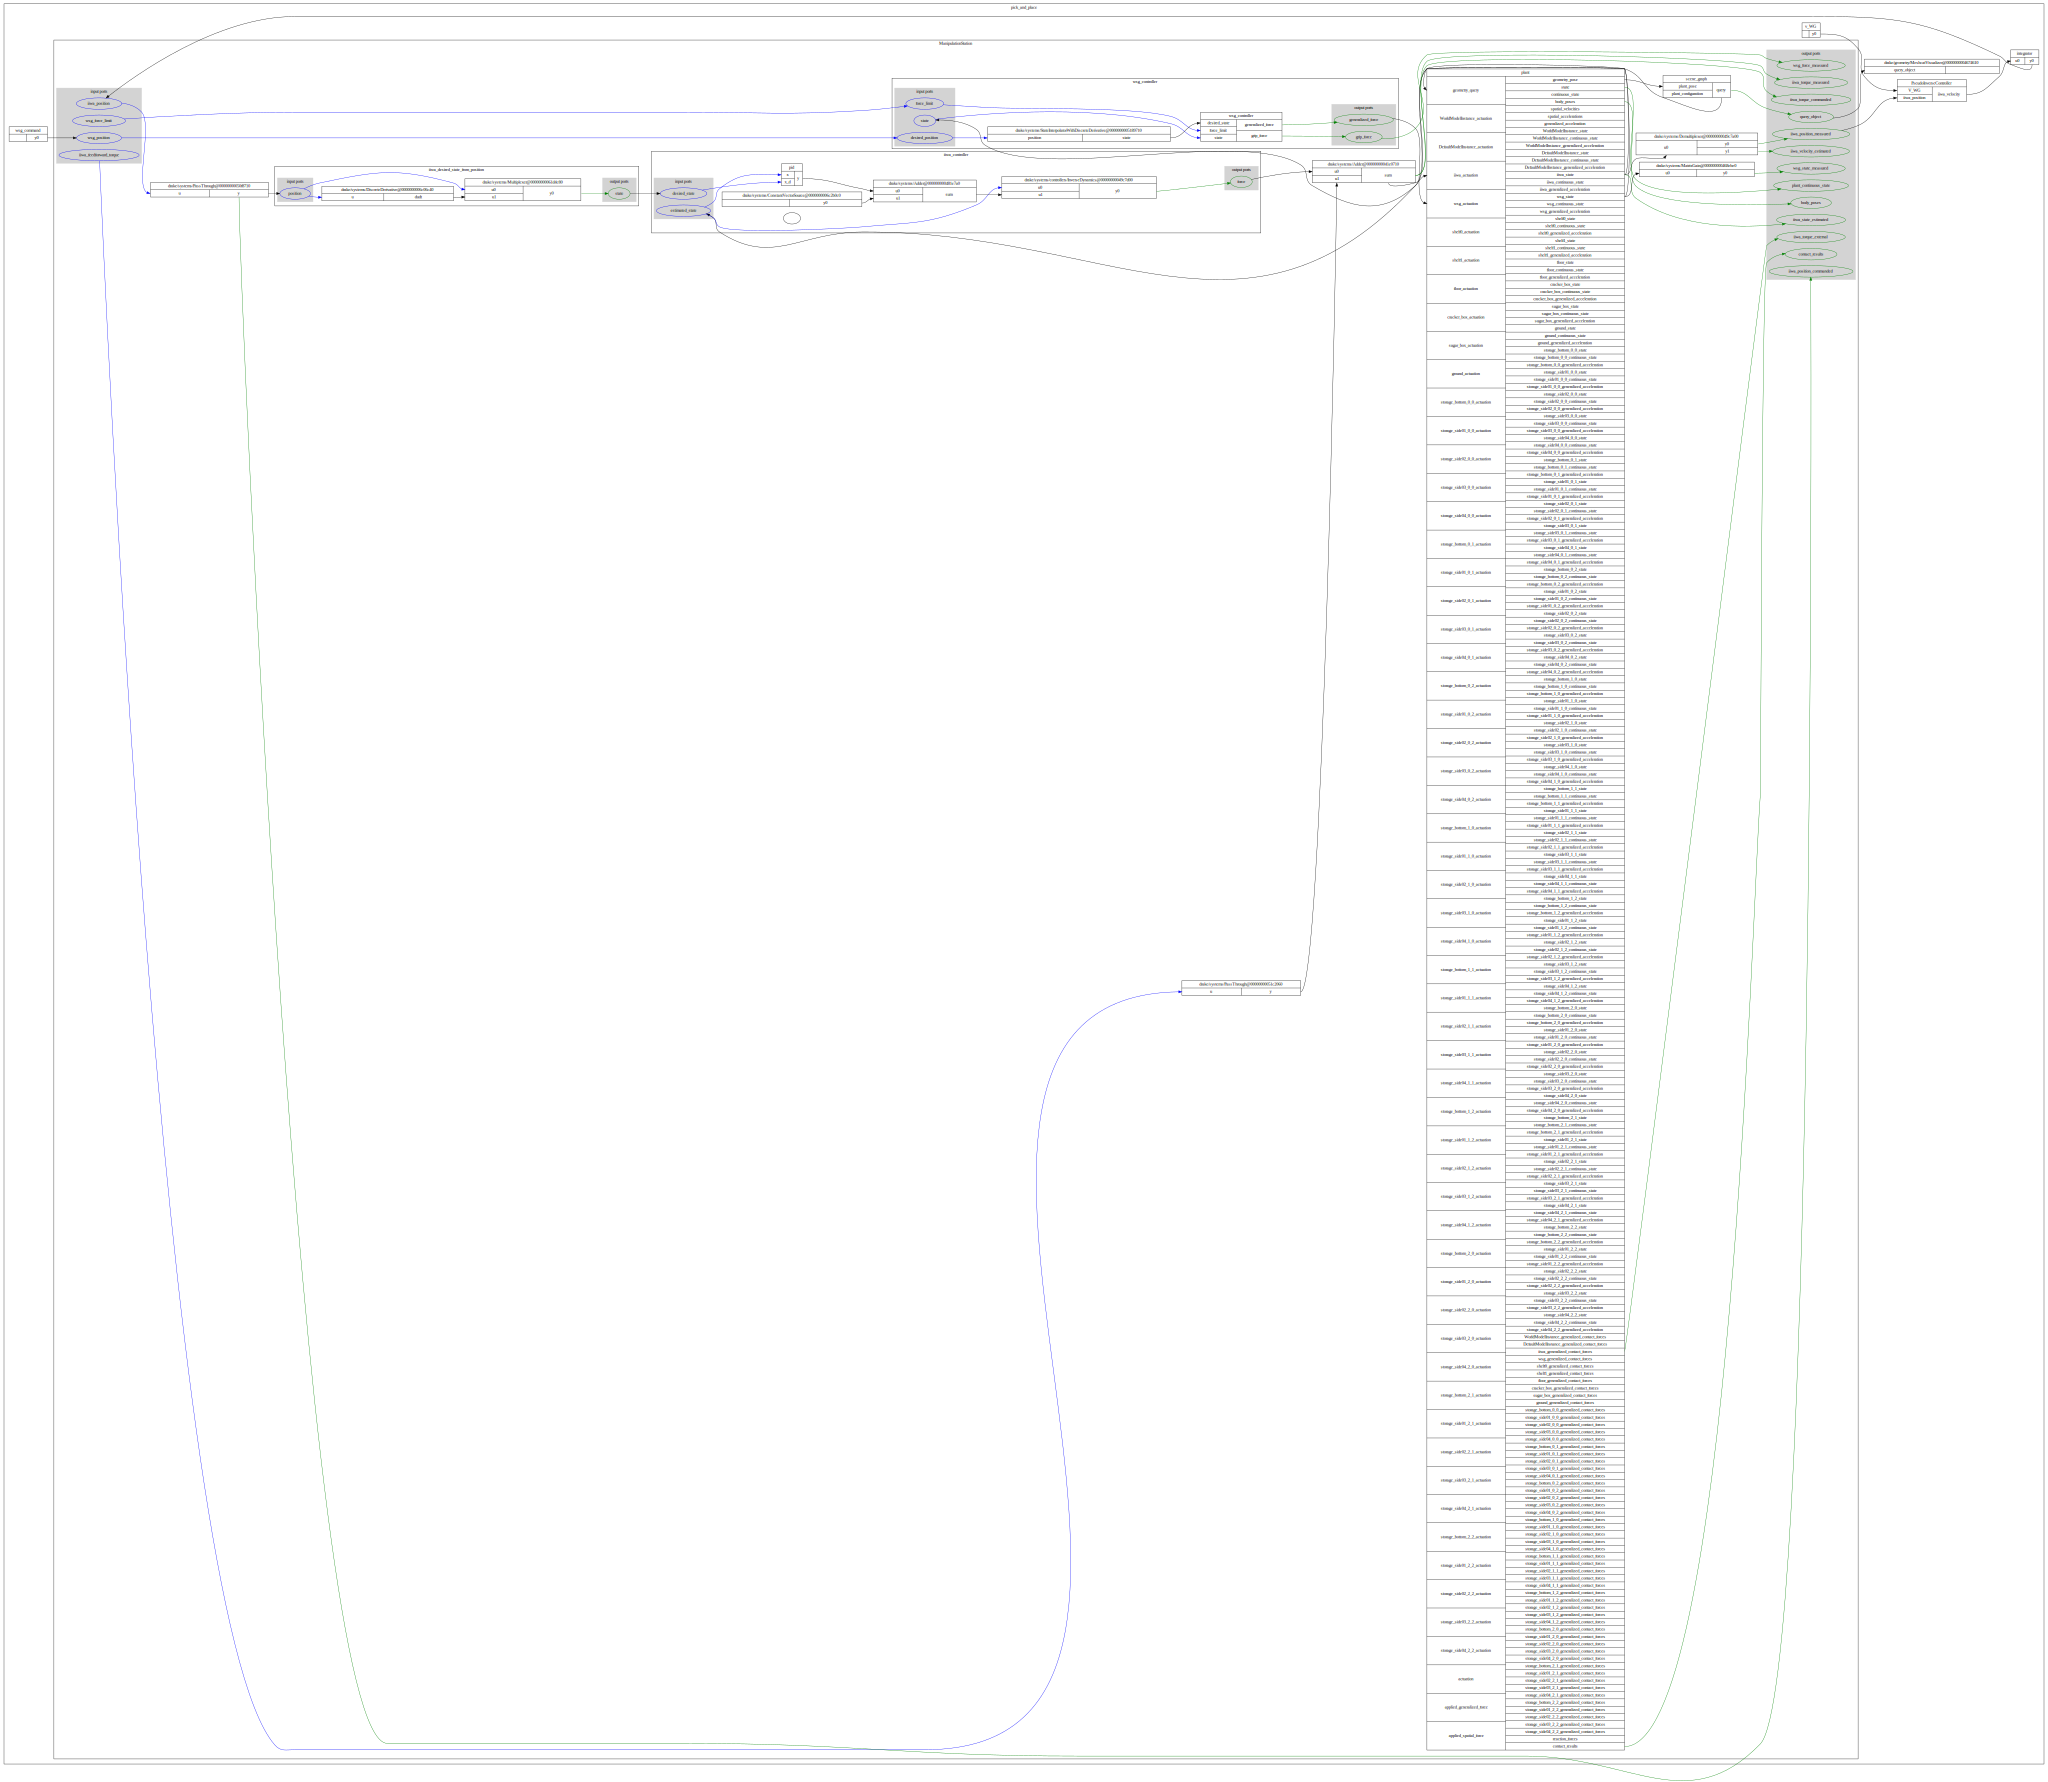

In [17]:
SVG(
    pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=3))[0].create_svg())


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7f664b82-843d-4a5a-bb36-dfd56c0fa9be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>